In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
import numpy
import pickle
from sklearn.model_selection import train_test_split
numpy.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
sys.path.append("../..")

In [3]:
import Bandelt_Encode_Decode.Bandelt_Encode_func as BN_Encode_func
import Bandelt_Encode_Decode.Bandelt_Decode_func as BN_Decode_func
import Bandelt_Encode_Decode.Bandelt_Node as BN

# Loading Data

In [4]:
X_Input_Alignment_Data = np.load('../../ALL_DATA/499_dataset_Input_Output/X_Input_Alignment_Data.npy')
Y_Output_BN_List_Data = np.load('../../ALL_DATA/499_dataset_Input_Output/Y_Output_BN_List_Data.npy')
File_Name_List = np.load('../../ALL_DATA/499_dataset_Input_Output/File_Name_List.npy')

In [5]:
with open('../../ALL_DATA/mapping_dic_dic.npy', 'rb') as input:
    mapping_dic_dic = pickle.load(input)
    
with open('../../ALL_DATA/mapping_dic_dic_decode.npy', 'rb') as input:
    mapping_dic_dic_decode = pickle.load(input)

In [6]:
print(X_Input_Alignment_Data.shape)
print(Y_Output_BN_List_Data.shape)
print(File_Name_List.shape)

(499, 100, 1000, 5)
(499, 100)
(499,)


In [7]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

# Change Y_Output_BN_List_Data Representation

In [8]:
Y_DENOMINATOR = []
for i in range(100):
    Y_DENOMINATOR.append(i+1)

In [9]:
Y_Output_BN_List_Data = np.true_divide(Y_Output_BN_List_Data, Y_DENOMINATOR)

## Shuffle Input Data

In [10]:
for i in range(X_Input_Alignment_Data.shape[0]):
    shuffle_indices_100 = random.sample(range(0, 100), 100)
    shuffle_indices_1000 = random.sample(range(0, 1000), 1000)
    tmp = X_Input_Alignment_Data[i][shuffle_indices_100]
    tmp = tmp[:, shuffle_indices_1000]
    X_Input_Alignment_Data[i] = tmp

## Training / Testing Dataset Partition (random seed 30)
Shuffle the order of samples

In [11]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_Input_Alignment_Data, Y_Output_BN_List_Data, test_size=0.15, shuffle= True)
TRAINING_RATION = 0.85

samples_count = X_Input_Alignment_Data.shape[0]
train_size = math.floor(TRAINING_RATION*samples_count)
shuffle_indices = random.sample(range(0, samples_count), samples_count)

indices_train = shuffle_indices[0:train_size]
indices_test = shuffle_indices[train_size:samples_count]

X_train = X_Input_Alignment_Data[indices_train,:]
Y_train = Y_Output_BN_List_Data[indices_train]
File_Name_train = File_Name_List[indices_train]

X_test = X_Input_Alignment_Data[indices_test,:]
Y_test = Y_Output_BN_List_Data[indices_test]
File_Name_test = File_Name_List[indices_test]

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', X_test.shape)

print('Y_train.shape : ', Y_train.shape)
print('Y_test.shape : ', Y_test.shape)

print('File_Name_train.shape : ', File_Name_train.shape)
print('File_Name_test.shape : ', File_Name_test.shape)

X_train.shape :  (424, 100, 1000, 5)
X_test.shape :  (75, 100, 1000, 5)
Y_train.shape :  (424, 100)
Y_test.shape :  (75, 100)
File_Name_train.shape :  (424,)
File_Name_test.shape :  (75,)


## Start Building Model

### Load Data

In [12]:
model = Sequential()

# Layer 1
model.add(Conv2D(1000, input_shape=X_Input_Alignment_Data.shape[1:], kernel_size=(100,1), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 2
model.add(Dense(1200))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 3
model.add(Dense(600))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 4
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))

# # Layer 2
# model.add(Conv2D(5, (1, 2)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 1)))

# # Layer 3
# model.add(Conv2D(2, (1, 2)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 1)))

# # Layer 4
# model.add(Conv2D(2, (1, 2)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 5
model.add(Flatten())
model.add(Dense(BRANCH_NUM, activation='tanh'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1000, 1000)     501000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1000, 1000)     4000      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1000, 1000)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1000, 1000)     0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1000, 1200)     1201200   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1000, 1200)     4800      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1000, 1200)    

In [15]:
def custom_loss_mean_squared_error(y_true, y_pred):
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return K.mean(K.square(y_pred*Y_DENOMINATOR - y_true*Y_DENOMINATOR), axis=-1)

# def custom_loss_mean_squared_logarithmic_error(y_true, y_pred):
#     if not K.is_tensor(y_pred):
#         y_pred = K.constant(y_pred)
#     y_true = K.cast(y_true, y_pred.dtype)
#     first_log = K.log(K.clip(y_pred, K.epsilon(), None)*Y_DENOMINATOR + 1.)
#     second_log = K.log(K.clip(y_true, K.epsilon(), None)*Y_DENOMINATOR + 1.)
#     return K.mean(K.square(first_log - second_log), axis=-1)

In [16]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss=custom_loss_mean_squared_error, optimizer='adam', metrics=['accuracy'])

In [17]:
loss_list_epoch= []
val_loss_list_epoch= []
RF_avg_distance_epoch = []
RF_list_distance_epoch = []

In [18]:
# Do first time to initial the tree!
print("******** Start fitting model ********")
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=2, epochs=1, verbose=1)
print(history.history['loss'])
loss_list_epoch.append(history.history['loss'][0])
val_loss_list_epoch.append(history.history['val_loss'][0])

print("******** Start calculating RF Distance ********")
RF_list_distance = []
for index in range(len(X_train)):
    tips_num = np.count_nonzero(np.sum(np.sum(X_train[index], axis=2), axis=1))
    tips_num_selec = tips_num - 3
#     print("tips_num: ", tips_num)
    #############################################
    #### Get X_train result BN encoding list ####
    #############################################
    X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 5)))
    X_train_results_trans = np.around(X_train_results[0]*Y_DENOMINATOR)[0:tips_num_selec]
    X_train_results_final = np.concatenate([[0], X_train_results_trans])
    
    ######################################
    #### Get Y_train BN encoding list ####
    ######################################
    Y_train_trans = np.around(Y_train[index]*Y_DENOMINATOR)[0:tips_num_selec]
    Y_train_final = np.concatenate([[0], Y_train_trans])

    #######################################################
    #### Decode both 'X_train' & 'Y_train' BN encoding ####
    #######################################################
    X_train_results_decode_tree, X_train_results_decode_newick = BN_Decode_func.Bandelt_Decode(list(map(int, X_train_results_final.tolist())), File_Name_train[index], mapping_dic_dic_decode)
    Y_train_decode_tree, Y_train_decode_newick = BN_Decode_func.Bandelt_Decode(list(map(int, Y_train_final.tolist())), File_Name_train[index], mapping_dic_dic_decode)

    ################################################################
    #### Dendropy tree creation both both 'X_train' & 'Y_train' ####
    ################################################################
    taxon_namespace = dendropy.TaxonSet()
    X_train_results_tree = dendropy.Tree.get(data=X_train_results_decode_newick, schema="newick", taxon_set=taxon_namespace)
    Y_train_tree = dendropy.Tree.get(data=Y_train_decode_newick, schema="newick", taxon_set=taxon_namespace)
    RF_distance = treecompare.symmetric_difference(X_train_results_tree, Y_train_tree)
    RF_list_distance.append(RF_distance)
RF_list_distance_epoch.append(RF_list_distance)
RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
print("RF_list_distance: ", RF_list_distance)
print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 424 samples, validate on 75 samples
Epoch 1/1
424/424 [==============================] - 36s 85ms/step - loss: 3611.0162 - accuracy: 0.1675 - val_loss: 3640.0123 - val_accuracy: 0.2000
[3611.0161524358787]
******** Start calculating RF Distance ********


/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead
/home/howard/miniconda3/lib/python3.7/site-packages/dendropy/datamodel/basemodel.py:158: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'taxon_set' will no longer be supported in future releases; use 'taxon_namespace' instead
  return cls.get_from_string(src=src, schema=schema, **kwargs)


RF_list_distance:  [108, 128, 132, 118, 124, 102, 126, 124, 114, 126, 108, 114, 90, 134, 102, 132, 112, 124, 114, 114, 80, 132, 106, 70, 124, 108, 132, 134, 118, 70, 94, 128, 110, 62, 132, 110, 94, 138, 118, 94, 136, 68, 120, 128, 92, 128, 142, 124, 140, 44, 134, 114, 102, 136, 108, 42, 42, 134, 60, 96, 128, 120, 116, 122, 124, 124, 122, 126, 98, 118, 108, 126, 108, 116, 94, 102, 128, 122, 114, 96, 120, 120, 110, 132, 124, 114, 126, 94, 112, 128, 104, 110, 76, 132, 112, 112, 114, 130, 118, 140, 108, 110, 132, 120, 46, 96, 108, 106, 38, 108, 46, 112, 108, 128, 124, 94, 124, 134, 52, 56, 76, 128, 124, 46, 114, 126, 106, 110, 84, 128, 112, 126, 130, 118, 120, 44, 114, 112, 80, 118, 128, 126, 122, 118, 114, 136, 98, 50, 96, 84, 116, 108, 108, 114, 114, 120, 108, 122, 128, 132, 70, 132, 130, 114, 114, 128, 126, 110, 70, 112, 130, 124, 134, 62, 106, 100, 80, 108, 96, 118, 106, 126, 102, 124, 108, 128, 124, 116, 132, 132, 124, 120, 114, 94, 122, 140, 92, 116, 116, 126, 122, 138, 128, 108, 114

In [19]:
# (5) Train
# history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=16, epochs=10, verbose=1)
for i in range(5):
    print("******** Start fitting model ********")
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=2, epochs=10, verbose=1)
    print(history.history['loss'])
    loss_list_epoch.append(history.history['loss'][0])
    val_loss_list_epoch.append(history.history['val_loss'][0])

    print("******** Start calculating RF Distance ********")
    RF_list_distance = []
    for index in range(len(X_train)):
        tips_num = np.count_nonzero(np.sum(np.sum(X_train[index], axis=2), axis=1))
        tips_num_selec = tips_num - 3
    #     print("tips_num: ", tips_num)
        #############################################
        #### Get X_train result BN encoding list ####
        #############################################
        X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 5)))
        X_train_results_trans = np.around(X_train_results[0]*Y_DENOMINATOR)[0:tips_num_selec]
        X_train_results_final = np.concatenate([[0], X_train_results_trans])

        ######################################
        #### Get Y_train BN encoding list ####
        ######################################
        Y_train_trans = np.around(Y_train[index]*Y_DENOMINATOR)[0:tips_num_selec]
        Y_train_final = np.concatenate([[0], Y_train_trans])

        #######################################################
        #### Decode both 'X_train' & 'Y_train' BN encoding ####
        #######################################################
        X_train_results_decode_tree, X_train_results_decode_newick = BN_Decode_func.Bandelt_Decode(list(map(int, X_train_results_final.tolist())), File_Name_train[index], mapping_dic_dic_decode)
        Y_train_decode_tree, Y_train_decode_newick = BN_Decode_func.Bandelt_Decode(list(map(int, Y_train_final.tolist())), File_Name_train[index], mapping_dic_dic_decode)

        ################################################################
        #### Dendropy tree creation both both 'X_train' & 'Y_train' ####
        ################################################################
        taxon_namespace = dendropy.TaxonSet()
        X_train_results_tree = dendropy.Tree.get(data=X_train_results_decode_newick, schema="newick", taxon_set=taxon_namespace)
        Y_train_tree = dendropy.Tree.get(data=Y_train_decode_newick, schema="newick", taxon_set=taxon_namespace)
        RF_distance = treecompare.symmetric_difference(X_train_results_tree, Y_train_tree)
        RF_list_distance.append(RF_distance)
    RF_list_distance_epoch.append(RF_list_distance)
    RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
    print("RF_list_distance: ", RF_list_distance)
    print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 424 samples, validate on 75 samples
Epoch 1/10
424/424 [==============================] - 37s 87ms/step - loss: 3608.6603 - accuracy: 0.1698 - val_loss: 3607.5818 - val_accuracy: 0.2000
Epoch 2/10
424/424 [==============================] - 37s 87ms/step - loss: 3625.9248 - accuracy: 0.1698 - val_loss: 3623.7786 - val_accuracy: 0.2000
Epoch 3/10
424/424 [==============================] - 36s 85ms/step - loss: 3638.7030 - accuracy: 0.1698 - val_loss: 3641.6517 - val_accuracy: 0.2000
Epoch 4/10
424/424 [==============================] - 36s 85ms/step - loss: 3632.4383 - accuracy: 0.1698 - val_loss: 3623.3605 - val_accuracy: 0.2000
Epoch 5/10
424/424 [==============================] - 36s 85ms/step - loss: 3630.4764 - accuracy: 0.1675 - val_loss: 3623.2410 - val_accuracy: 0.2000
Epoch 6/10
424/424 [==============================] - 36s 85ms/step - loss: 3630.6648 - accuracy: 0.1675 - val_loss: 3623.5024 - val_accuracy: 0.2000
Epoch 7/10
424/42

/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [108, 128, 132, 118, 124, 102, 126, 124, 114, 126, 108, 114, 90, 134, 102, 132, 114, 124, 114, 114, 80, 132, 106, 68, 124, 108, 132, 132, 118, 70, 94, 128, 110, 62, 132, 110, 94, 138, 118, 94, 136, 68, 120, 128, 92, 128, 142, 124, 140, 44, 134, 114, 102, 136, 108, 42, 42, 134, 60, 96, 128, 120, 116, 124, 124, 124, 122, 126, 98, 118, 108, 126, 108, 116, 92, 102, 128, 122, 114, 96, 120, 120, 110, 132, 124, 114, 126, 96, 112, 128, 104, 110, 76, 132, 112, 112, 114, 130, 118, 140, 108, 110, 132, 120, 46, 96, 108, 108, 38, 108, 46, 112, 108, 128, 124, 94, 124, 134, 52, 56, 76, 128, 124, 46, 114, 126, 106, 110, 84, 128, 112, 126, 130, 118, 120, 44, 114, 112, 80, 118, 128, 126, 122, 118, 114, 136, 98, 50, 96, 84, 116, 108, 108, 114, 114, 120, 108, 122, 128, 132, 70, 132, 130, 112, 114, 128, 126, 110, 70, 112, 130, 124, 134, 62, 106, 100, 80, 108, 96, 118, 106, 126, 102, 124, 110, 128, 124, 116, 132, 132, 124, 120, 114, 96, 122, 140, 92, 116, 116, 126, 122, 138, 128, 108, 114

424/424 [==============================] - 36s 85ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_loss: 3628.2117 - val_accuracy: 0.2000
Epoch 2/10
424/424 [==============================] - 35s 83ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_loss: 3628.2117 - val_accuracy: 0.2000
Epoch 3/10
424/424 [==============================] - 35s 82ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_loss: 3628.2117 - val_accuracy: 0.2000
Epoch 4/10
424/424 [==============================] - 36s 85ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_loss: 3628.2117 - val_accuracy: 0.2000
Epoch 5/10
424/424 [==============================] - 35s 83ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_loss: 3628.2117 - val_accuracy: 0.2000
Epoch 6/10
424/424 [==============================] - 35s 83ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_loss: 3628.2117 - val_accuracy: 0.2000
Epoch 7/10
424/424 [==============================] - 35s 83ms/step - loss: 3637.5756 - accuracy: 0.1675 - val_

In [20]:
model.save('./output/CNN_model_03.h5')

## Load the Model

In [21]:
# model = keras.models.load_model('./output/CNN_model_03.h5')

## Plot training and validation loss

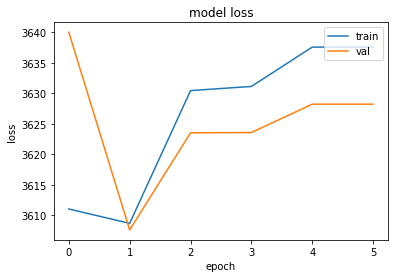

In [22]:
plt.plot(loss_list_epoch)
plt.plot(val_loss_list_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## X_train plot (Before transformation)

In [23]:
X_train_results = model.predict(X_train)

In [24]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

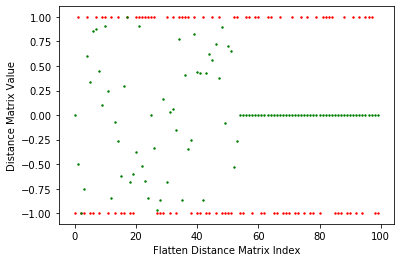

In [25]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train[train_show_index].shape[0]), Y_train[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

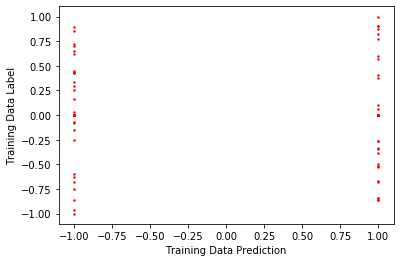

In [26]:
plt.scatter(X_train_results[train_show_index], Y_train[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [27]:
X_train_results_resh= X_train_results.reshape((1, 424*100))
Y_train_resh = Y_train.reshape((1, 424*100))

<function matplotlib.pyplot.show(*args, **kw)>

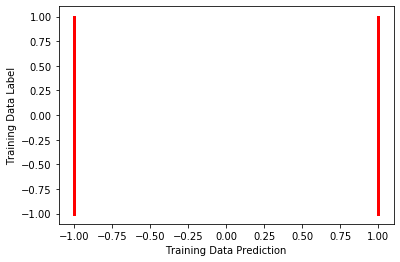

In [28]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_train plot (After transformation)

In [29]:
X_train_results_trans = np.around(np.multiply(X_train_results, Y_DENOMINATOR))

In [30]:
Y_train_trans = np.multiply(Y_train, Y_DENOMINATOR)

In [31]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

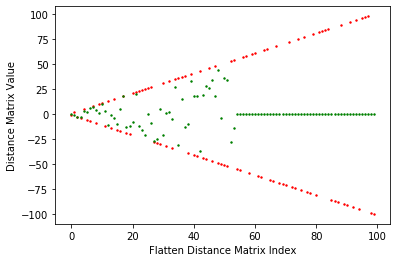

In [32]:
plt.scatter(range(X_train_results_trans[train_show_index].shape[0]), X_train_results_trans[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train_trans[train_show_index].shape[0]), Y_train_trans[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

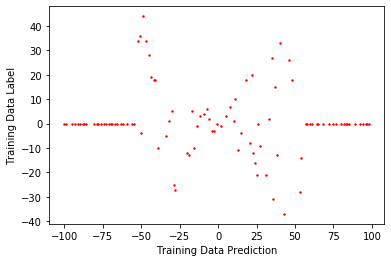

In [33]:
plt.scatter(X_train_results_trans[train_show_index], Y_train_trans[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [34]:
X_train_results_resh= X_train_results_trans.reshape((1, 424*100))
Y_train_resh = Y_train_trans.reshape((1, 424*100))

<function matplotlib.pyplot.show(*args, **kw)>

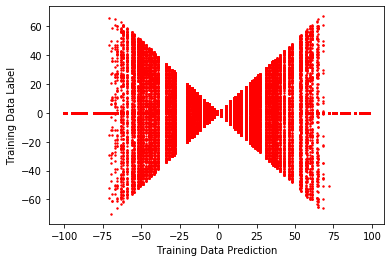

In [35]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot  (Before transformation)

In [36]:
X_test_results = model.predict(X_test)

In [37]:
test_show_index = 4

Text(0, 0.5, 'Distance Matrix Value')

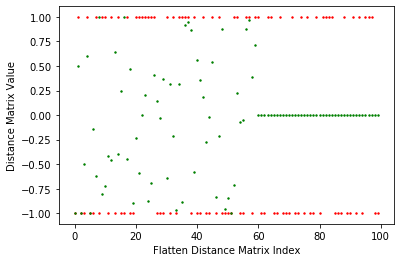

In [38]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test[test_show_index].shape[0]), Y_test[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

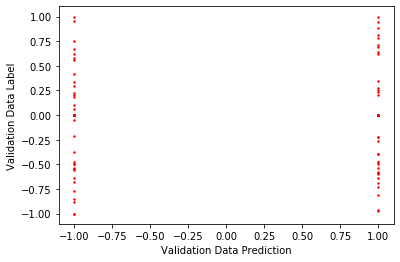

In [39]:
plt.scatter(X_test_results[train_show_index], Y_test[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [40]:
X_test_results_resh= X_test_results.reshape((1, 75*100))
Y_test_resh = Y_test.reshape((1, 75*100))

<function matplotlib.pyplot.show(*args, **kw)>

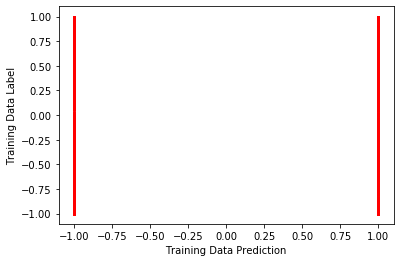

In [41]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot  (After transformation)

In [42]:
X_test_results_trans = np.around(np.multiply(X_test_results, Y_DENOMINATOR))

In [43]:
Y_test_trans = np.multiply(Y_test, Y_DENOMINATOR)

In [44]:
test_show_index = 10

Text(0, 0.5, 'Distance Matrix Value')

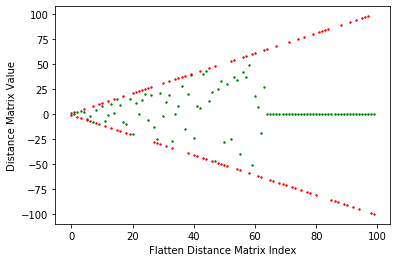

In [45]:
plt.scatter(range(X_test_results_trans[test_show_index].shape[0]), X_test_results_trans[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test_trans[test_show_index].shape[0]), Y_test_trans[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

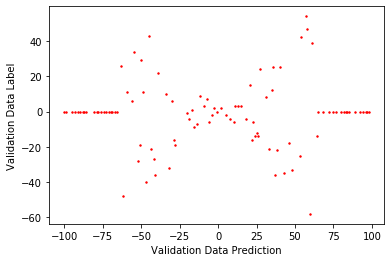

In [46]:
plt.scatter(X_test_results_trans[train_show_index], Y_test_trans[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [47]:
X_test_results_resh= X_test_results_trans.reshape((1, 75*100))
Y_test_resh = Y_test_trans.reshape((1, 75*100))

<function matplotlib.pyplot.show(*args, **kw)>

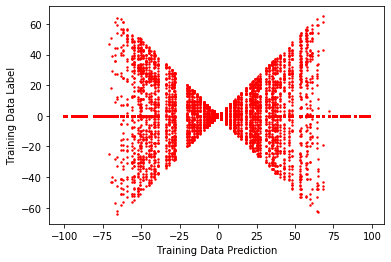

In [48]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot RF distance

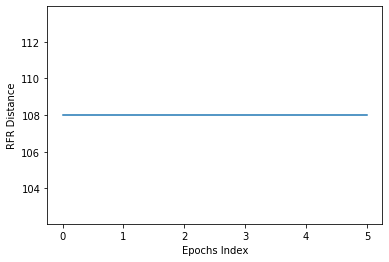

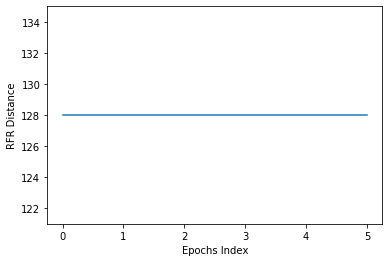

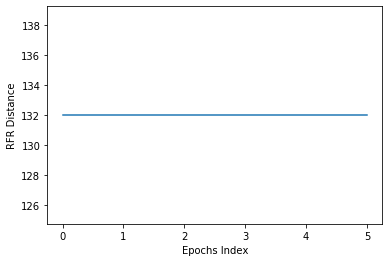

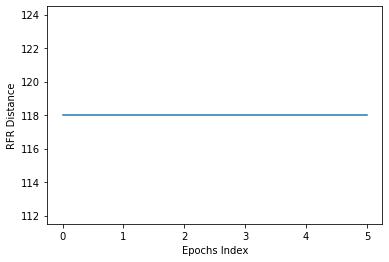

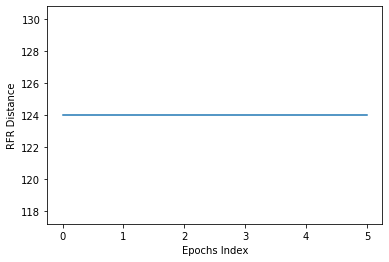

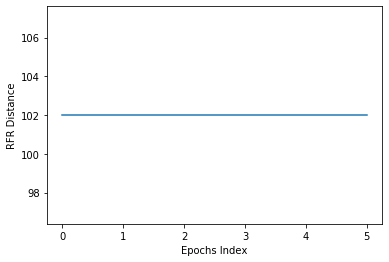

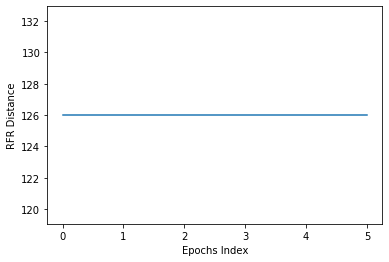

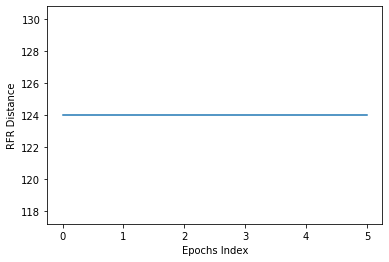

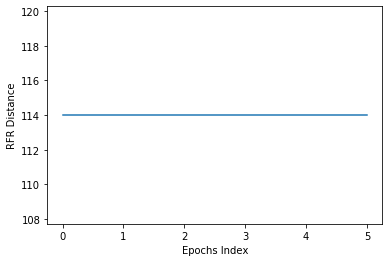

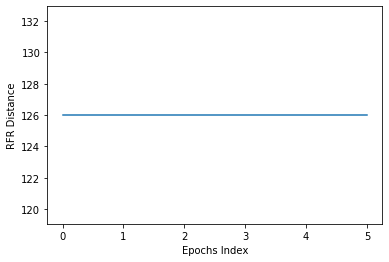

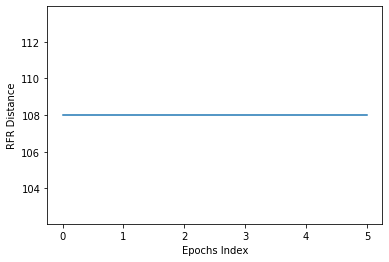

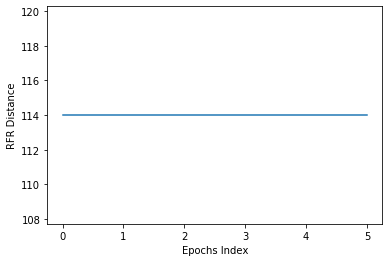

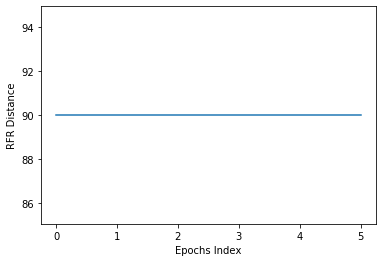

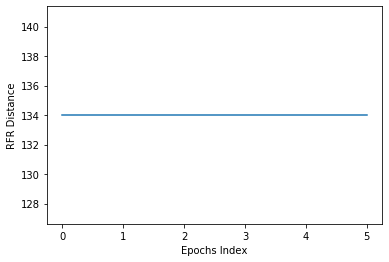

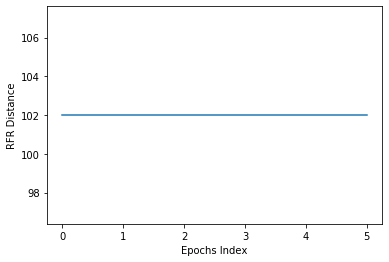

In [49]:
for index in range(15):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

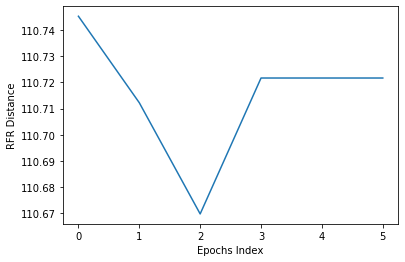

In [50]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()